In [1]:

import scipy.stats as stats 

import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

## Chapter 4 - Inferences with Gaussians

### 4.1 Inferring a mean and standard deviation

* Inferring the mean and variance of a Gaussian distribution.


![](./img/4.1.PNG)


$$P(\mu | x) \propto P(\mu)P(x|\mu)$$

* **Precision**은 분산의 역수로 크면 클 수록 더 안정적이라는 것을 표현하기 위한 베이지안에서의 표현식

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma, mu]
Sampling 10 chains: 100%|██████████| 15000/15000 [00:03<00:00, 4369.89draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6397213307797319, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9088253914381154, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


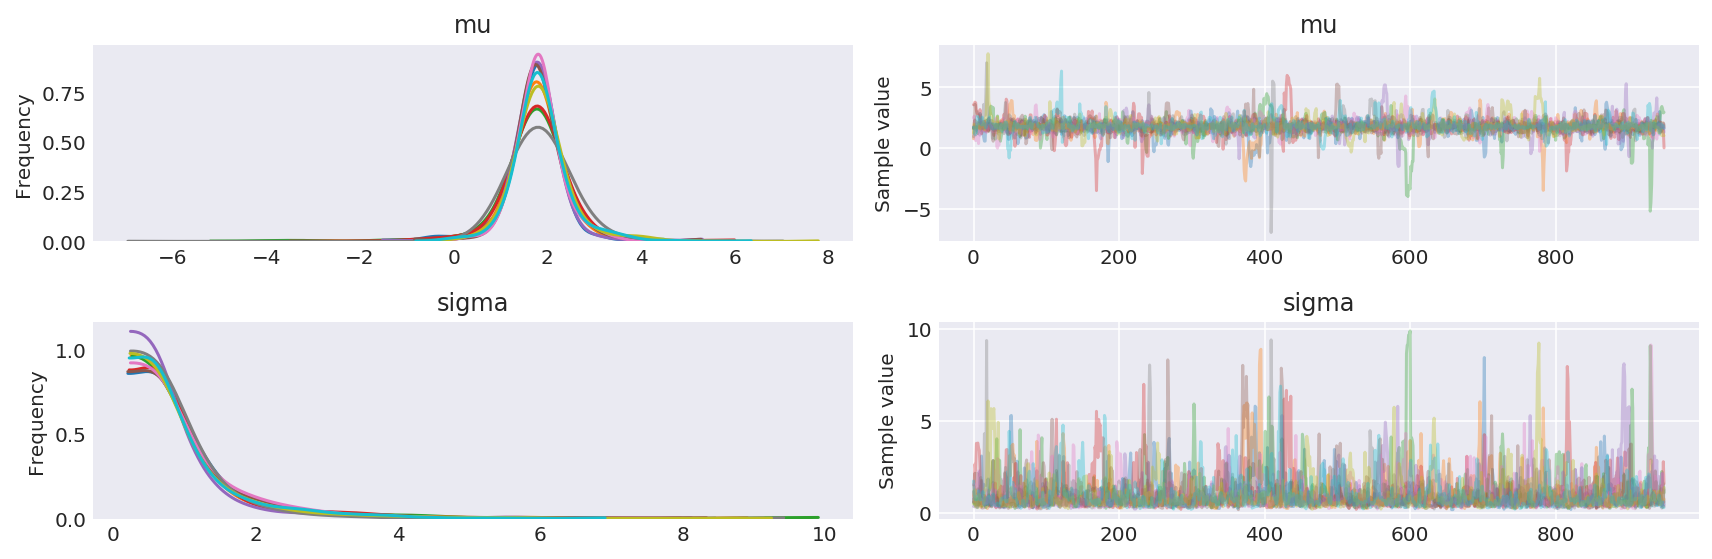

In [2]:
x = np.array([1.1, 1.9, 2.3, 1.8])
n = len(x)
    
with pm.Model() as model1:
    # prior
    mu = pm.Normal('mu', mu=0, tau=.001)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # observed
    xi = pm.Normal('xi',mu=mu, tau=1/(sigma**2), observed=x)
    # inference
    trace = pm.sample(1000, cores=10)

pm.traceplot(trace[50:]);

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The mu estimation is: 1.790
The sigma estimation is: 1.007


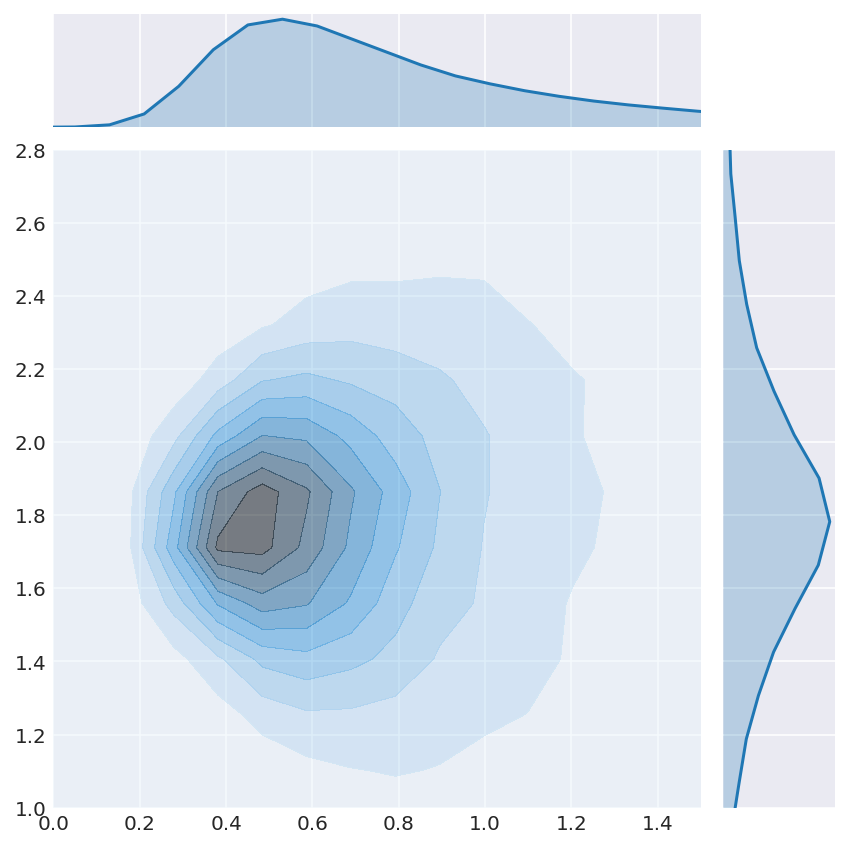

In [3]:
y = trace['mu']
x = trace['sigma']
sns.jointplot(x, y, alpha=.5 , kind='kde' , ylim=(1.0, 2.8) , xlim=(0.0, 1.5));

print('The mu estimation is: %.3f' % y.mean())
print('The sigma estimation is: %.3f' % x.mean())

## Note from Junpeng Lao

* There are might be divergence warning (Uniform prior on sigma is not a good idea in general), which you can further visualize below




Number of Divergent 3
Percentage of Divergent 0.00300


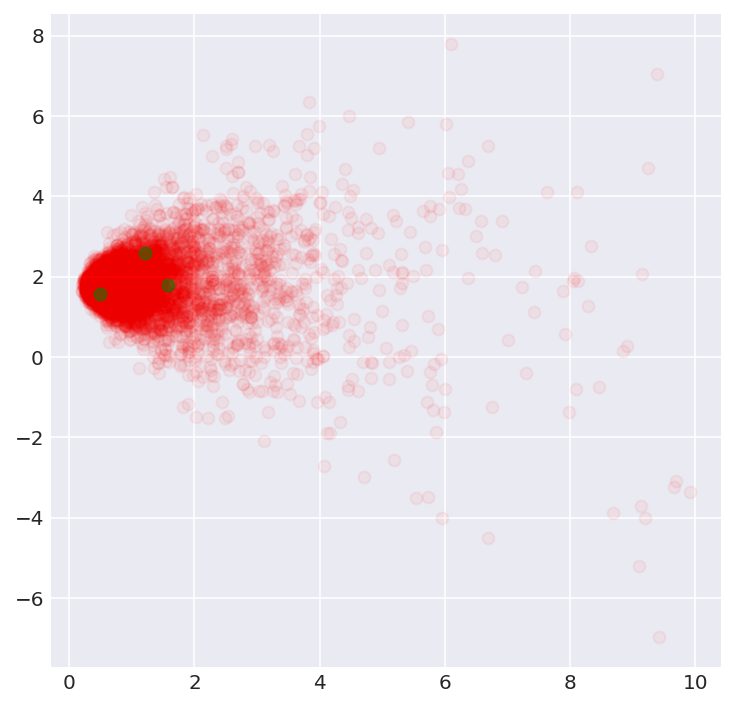

In [4]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace)
print('Percentage of Divergent %.5f' % divperc)

# scatter plot for the identifcation of the problematic neighborhoods in parameter space
plt.figure(figsize=(6, 6))
plt.scatter(x[divergent == 0], y[divergent == 0], color='r', alpha=.05)
plt.scatter(x[divergent == 1], y[divergent == 1], color='g', alpha=.5);

## Improper Prior [1](https://www.quora.com/What-is-an-improper-prior-and-when-is-it-used-in-Bayesian-Inference) [2](https://www.lesswrong.com/posts/hBBYHHemYWvzDxNyP/against-improper-priors) [3](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors)
* 적분을 해도 1이 안되는 것
* 한마디로 사전 분포가 굳이 어떠한 분포일 필요가 없을 경우에 사용 가능하다.

$$P(Y|X) \propto P(Y)P(X|Y)$$
$$P(Y|X) \propto w(Y)P(X|Y)$$

$$P(A_i|B) = \frac{P(B|A_i)P(A_i)}{\sum_{j} P(B|A_j)P(A_j)}$$

* P(Y) 가 사전 분포 역할을 하는데, 이것은 결국 weight 가중치를 주는 역할을 하는 거라고 한다.
* 그래서 이것을 임의로 상수로 대체하게되면 위의 식과 같이 분자와 분모에 약분이 가능하게 된다. 
* 이것의 의미를 해석하자면 B와 A가 indepenet 하다고 할 수 있다. 
* 이러한 것을 **Improper Prior** 이나 **Uninformative Priors**라고 하기도 한다.

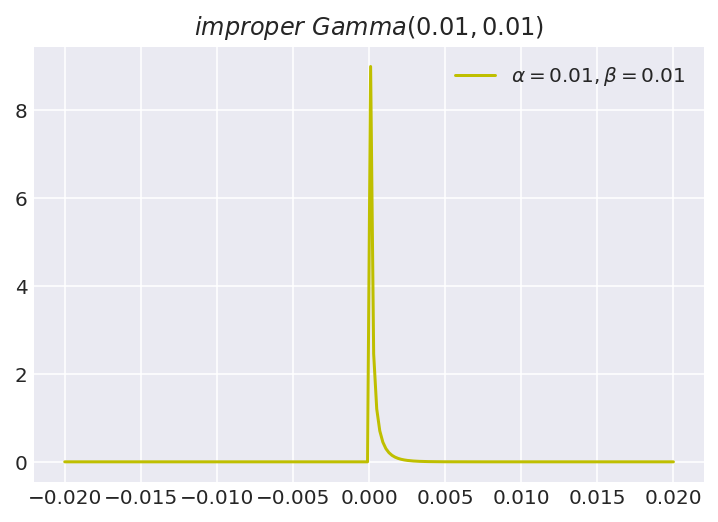

In [5]:
## gamma( 0.01 , 0.01 )
x = np.linspace (-0.02, 0.02, 200) 
y1 = stats.gamma.pdf(x, a= 0.001 , scale=0.001)
plt.plot(x, y1, "y-", label=(r'$\alpha=0.01, \beta=0.01$')) 
plt.title("$improper \ Gamma(0.01, 0.01)$")
plt.legend()
plt.show()

## 4,2 The seven scientists

* The Model : 

![](./img/4.2.PNG)

$$\mu \sim Gaussian(0, 0.001)$$

$$\sigma_i \sim InvSqrtGamma(0.001, 0.001)$$

$$\lambda_i \sim Gamma(0.001, 0.001)$$

$$\sigma = \frac{1}{\sqrt(\lambda_i)}$$

$$x_i \sim Gaussian(\mu , \frac{1}{\sigma_i^2}) = Gaussian(\mu , \lambda_i) $$

$\mu$ is same for all seven scientists , while standard $\sigma$ are different

* 핵심 문제는 측정 된 양을 통해서 사후 분포를 찾아서 측정에 대한 값을 추정하는 것

* 가정
    * 1. 모든 과학자들이 평균이 같은 가우시안 분포를 따른다
    * 2. 표준 편차는 각각 다르다.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [lambda1, mu]
Sampling 10 chains: 100%|██████████| 15000/15000 [00:06<00:00, 2190.95draws/s]
The acceptance probability does not match the target. It is 0.8829771818581899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012181412023332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828658708238515, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,9.900500,0.163707,0.005338,9.583751e+00,10.123547,524.989585,1.007782
lambda1__0,0.000744,0.001072,0.000012,1.058114e-11,0.002877,8506.214712,0.999866
lambda1__1,0.024601,0.034669,0.000372,1.046470e-09,0.096113,10412.507053,0.999713
lambda1__2,0.947650,27.246532,0.446019,3.707073e-09,1.414156,2743.772609,1.001916
lambda1__3,222.681625,431.659697,5.434171,5.359939e-05,1043.352865,6134.162242,0.999907
lambda1__4,29.739428,132.390960,2.111739,8.678617e-09,90.284823,3592.349370,1.000681
lambda1__5,228.983245,423.395242,5.436300,1.346768e-05,1061.365056,4979.724286,1.000187
lambda1__6,99.595741,260.229057,3.117835,1.205648e-07,457.254313,6703.256783,0.999967


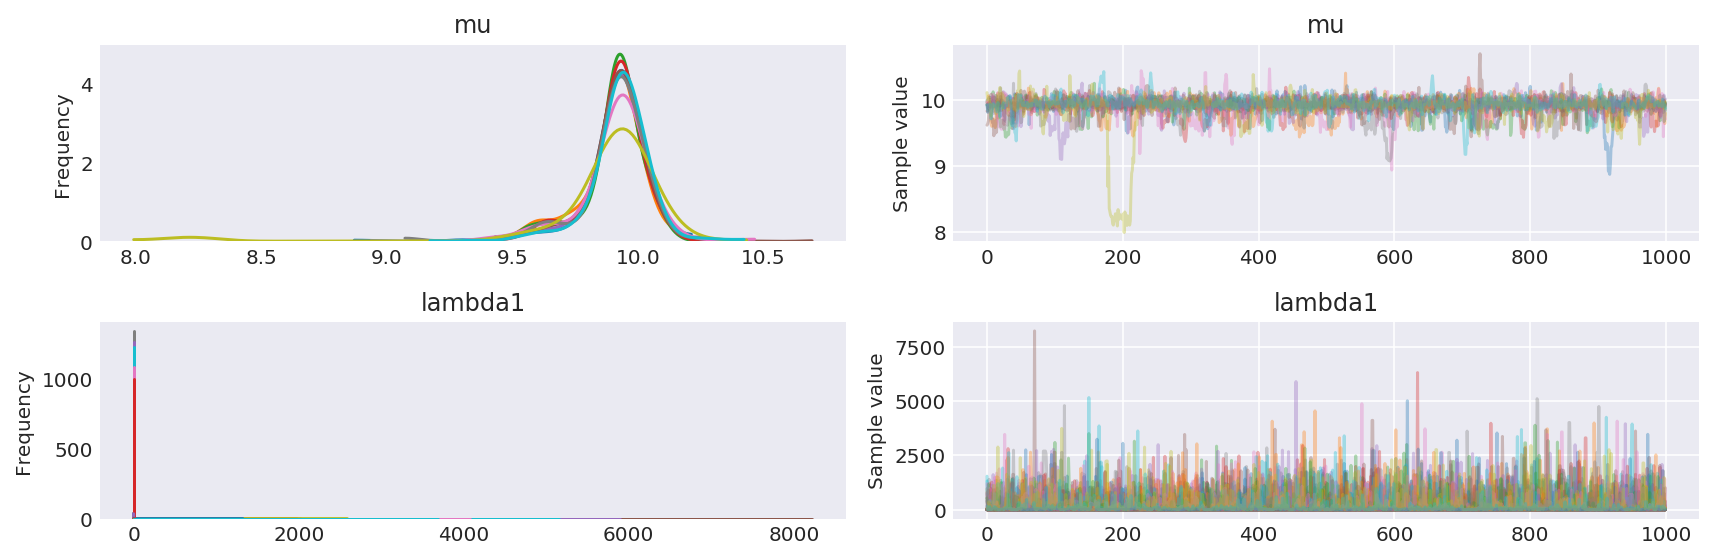

In [6]:

# data
x = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])
n = len(x)

with pm.Model() as model2: 
    # prior
    # 평균은 같은 분포
    mu = pm.Normal('mu', mu=0, tau=0.001)
    # 표쥰 편차는 다르게 주기
    lambda1 = pm.Gamma('lambda1', alpha=0.001, beta=0.001, shape=n)
    
    
    # observed
    
    xi = pm.Normal('xi', mu=mu, tau=lambda1, observed=x)

    # inference
    trace2 = pm.sample(1000, cores=10)

pm.traceplot(trace2);
pm.summary(trace2)

* lambda 의 평균이 MAP(Maximum A Posteriori)라 할 수 있다.
    * lambda_0 은 0.000738 로 아주 작으므로, lambda는 분산의 역수이므로 분산이 아주 크다는 것을 알 수 있다.
    * lambd_5 은 231.663754 로 다른 것들이 비해 제일 크므로 분산이 가장 작다는 것을 알 수 있다. 하지만 sd도 커서 불확실하다는 것을 알 수 있다.
    
* **Rhat**  [URL](http://www.kgeography.or.kr/homepage/kgeography/www/old/publishing/journal/49/05/09.pdf)
    * Rhat은 체인 간 변동과 체인 내에서의 변동을 비교한 수치로 시뮬레이션 초기에는 그 수치가 매우 크지만 일단 수렴 상태에 도달하면 1.0에 가까워지며, 1.1 이하의 Rhat값을 보이면 의도한 사후 확률분포에 수렴하였다고 판단할 수 있다(Gelman & Hill, 2007) 
    
* **n_eff** [URL](https://wsyang.com/2018/07/bayesian-simple-regression-using-rstan/)
    * 자기 상관(auto correlation) 등으로 부터 판단한 유효 MCMC 샘플의 수이다. 이 값이 작으면 모수가 수렴하기 어렵다는 것이므로 모형 개선이 필요하다는 힌트가 된다  

* **Highest Posterior Density** [HPD]



<div style = "text-align: center;">
    <img src = "./img/hpd.png">
</div>


<div style = "text-align: center;"> 
<font size = 8> 4.3 Repeated measurement of IQ </font>
</div>

<div style = "text-align: center;"> 
<font size = 5>The Model </font>
</div>

<div style = "text-align: center;" >
<img src ="./img/4.3.PNG">    
</div>


$$ \mu_i \sim Uniform(0, 300)$$
$$ \sigma \sim Uniform(0,100)$$
$$ x_{i,j} \sim Gaussian(\mu_i , \frac{1}{\sigma^2})$$

Different $\mu$  Common Precision $Precision = \frac{1}{\sigma^2}$

* 반복된 IQ TEST 차이는 평균이 0이라하고 Precision은 알 수 없는 가우신 분포를 따른다고 가정한다.
* 가우시안의 잔차가 IQ TEST의 정확도와 연관이 있다고 할 수 있다.
* 각 사람들의 IQ의 값은 Scale을 0 , 300을 가지는 Uniform으로 한다.
* 편차는 0~100 정도의 Uniform을 따른다하자.
* 실제 코드는 $sigma$ 를 Uniform에서 Gamma Prior로 변경하는 것이 더 안정적이라고 한다.

In [7]:
# Data Exercise 4.3.3
y = np.array([[94, 95, 96], [109, 110, 110], [154, 155, 156]])
ntest = y.shape[1] # 3 
nsbj = y.shape[0] # 3

import sys
eps = sys.float_info.epsilon

with pm.Model() as model3:
    # mu_i ~ Uniform(0, 300)
    # notices the shape here need to be properly 
    # initualized to have the right repeated measure
    mui = pm.Uniform('mui', 0, 300, shape=(nsbj, 1))

    # sg ~ Uniform(0, 100)
    # sg = pm.Uniform('sg', .0, 100)
    
    # It is more stable to use a Gamma prior
    lambda1 = pm.Gamma('lambda1', alpha=.01, beta=.01)
    sg = pm.Deterministic('sg',1 / np.sqrt(lambda1))
    
    # y ~ Normal(mu_i, sg)
    yd = pm.Normal('y', mu=mui, sd=sg, observed=y)
    
    trace3 = pm.sample(1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda1, mui]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1439.06draws/s]
The acceptance probability does not match the target. It is 0.8921111770716491, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mui__0_0,95.010464,0.608008,0.013568,93.662247,96.200913,2353.815369,0.999854
mui__1_0,109.661554,0.618153,0.014970,108.451142,110.928384,1719.618183,0.999599
mui__2_0,154.994515,0.615223,0.015476,153.726356,156.148526,1734.317980,1.000954
lambda1,1.302621,0.746907,0.023697,0.158161,2.775629,901.166606,1.003254
sg,1.006045,0.350606,0.011820,0.504800,1.683330,814.667928,1.000741


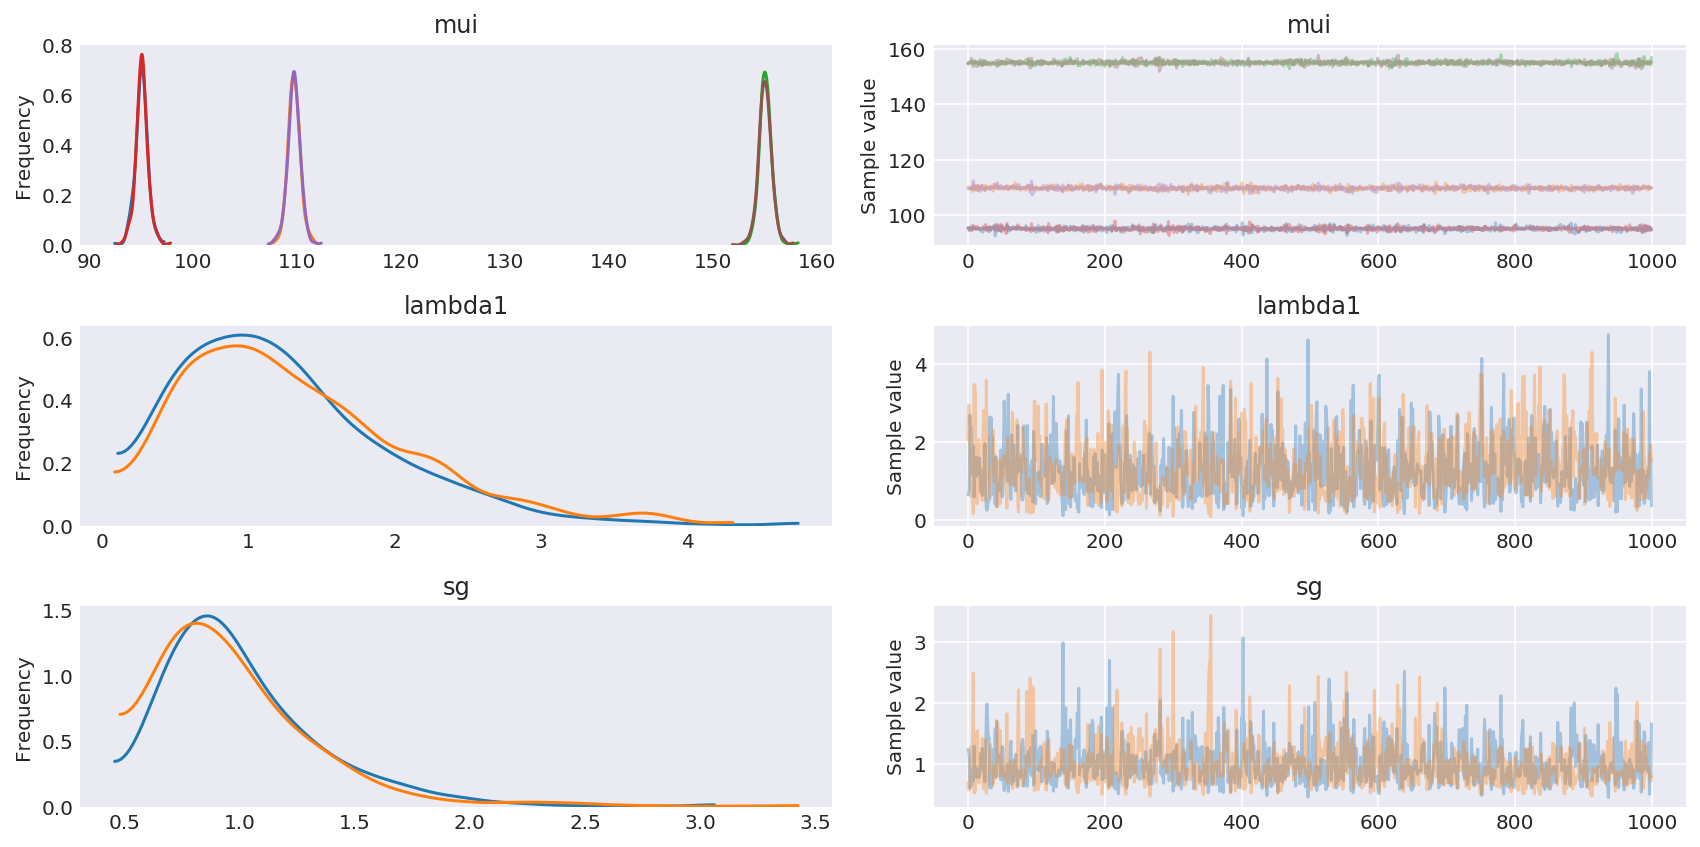

In [8]:
pm.traceplot(trace3);
pm.summary(trace3)

In [9]:
# Data Exercise 4.3.3
y = np.array([[54, 95, 146 , 160 , 100],
              [55, 110, 160 , 180 , 200],
              [154, 155, 156 , 155 , 150]])
ntest = 5
nsbj = 3

import sys
eps = sys.float_info.epsilon

with pm.Model() as model3:
    # mu_i ~ Uniform(0, 300)
    # notices the shape here need to be properly 
    # initualized to have the right repeated measure
    mui = pm.Uniform('mui', 0, 300, shape=(nsbj, 1))

    # sg ~ Uniform(0, 100)
    # sg = pm.Uniform('sg', .0, 100)
    
    # It is more stable to use a Gamma prior
    lambda1 = pm.Gamma('lambda1', alpha=.01, beta=.01)
    sg = pm.Deterministic('sg',1 / np.sqrt(lambda1))
    
    # y ~ Normal(mu_i, sg)
    yd = pm.Normal('y', mu=mui, sd=sg, observed=y)
    
    trace3 = pm.sample(1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda1, mui]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1511.79draws/s]


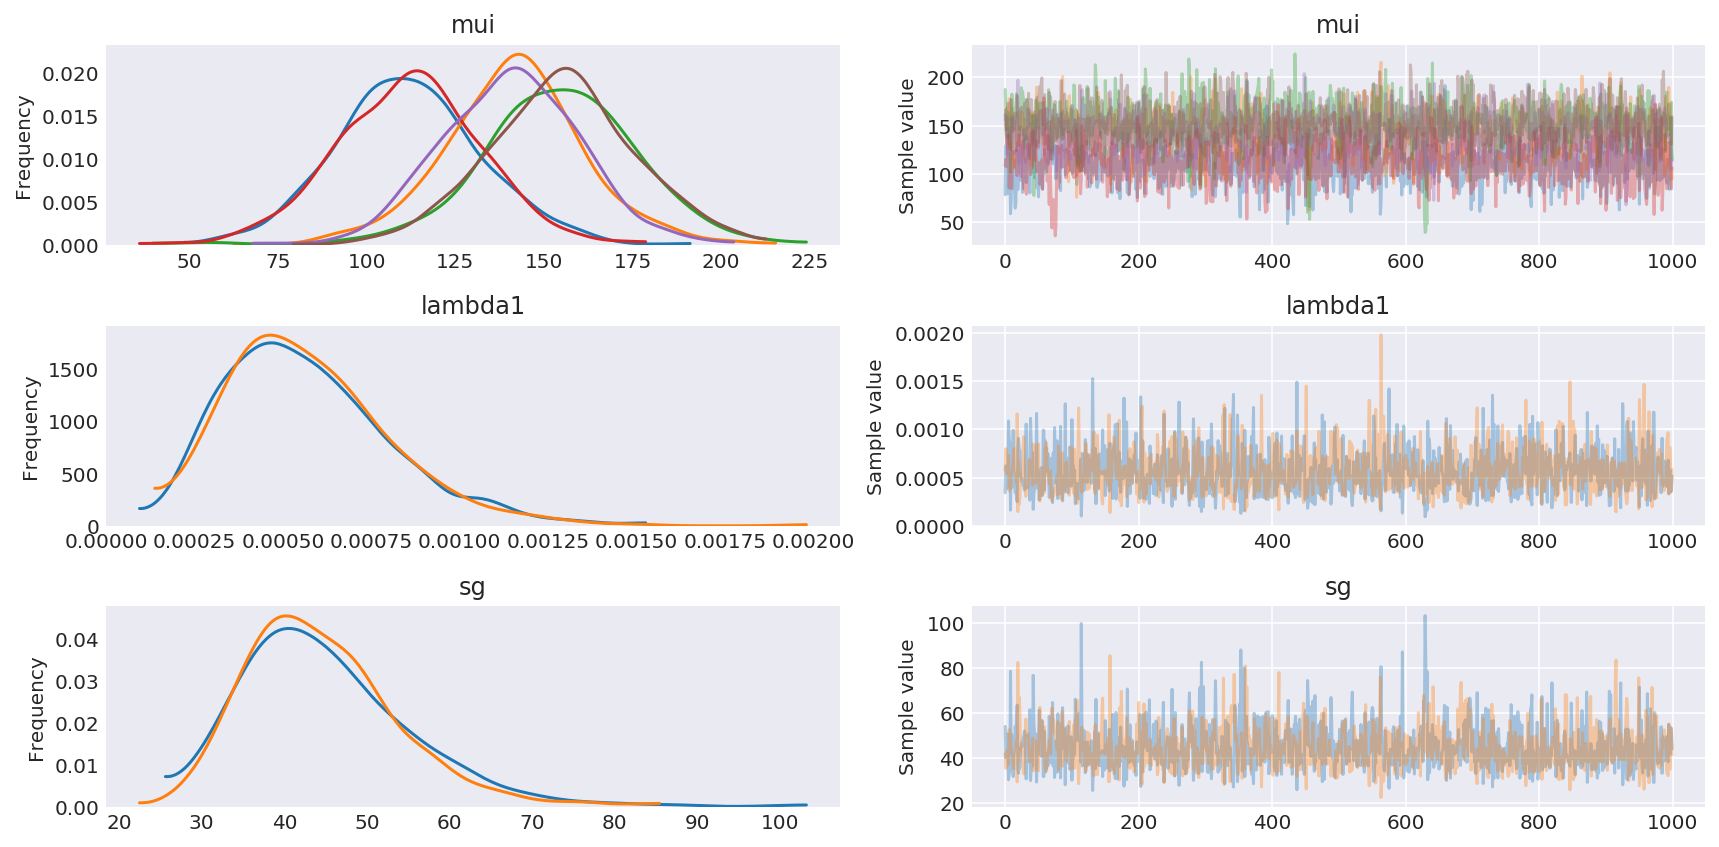

In [14]:
pm.traceplot(trace3);


In [15]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mui__0_0,111.354211,20.351094,0.525983,68.624860,149.363773,1478.602751,0.999500
mui__1_0,140.757448,19.562394,0.439458,103.138381,181.796738,1809.572780,1.000166
mui__2_0,154.014455,21.701243,0.561427,114.411325,199.010885,1437.202016,1.000259
lambda1,0.000569,0.000231,0.000006,0.000195,0.001057,1417.039239,0.999667
sg,44.668236,9.741407,0.265784,27.169772,62.701425,1272.356262,1.000565


<center><font size = 10> 
Pymc3 Plot Functions </font>
<br>
<font size = 5 >
autocorrplot <br>
densityplot <br>
energyplot <br>
pairplot <br>
plot_posterior <br>
traceplot <br>
</font>
</center>



In [16]:
from pymc3 import *

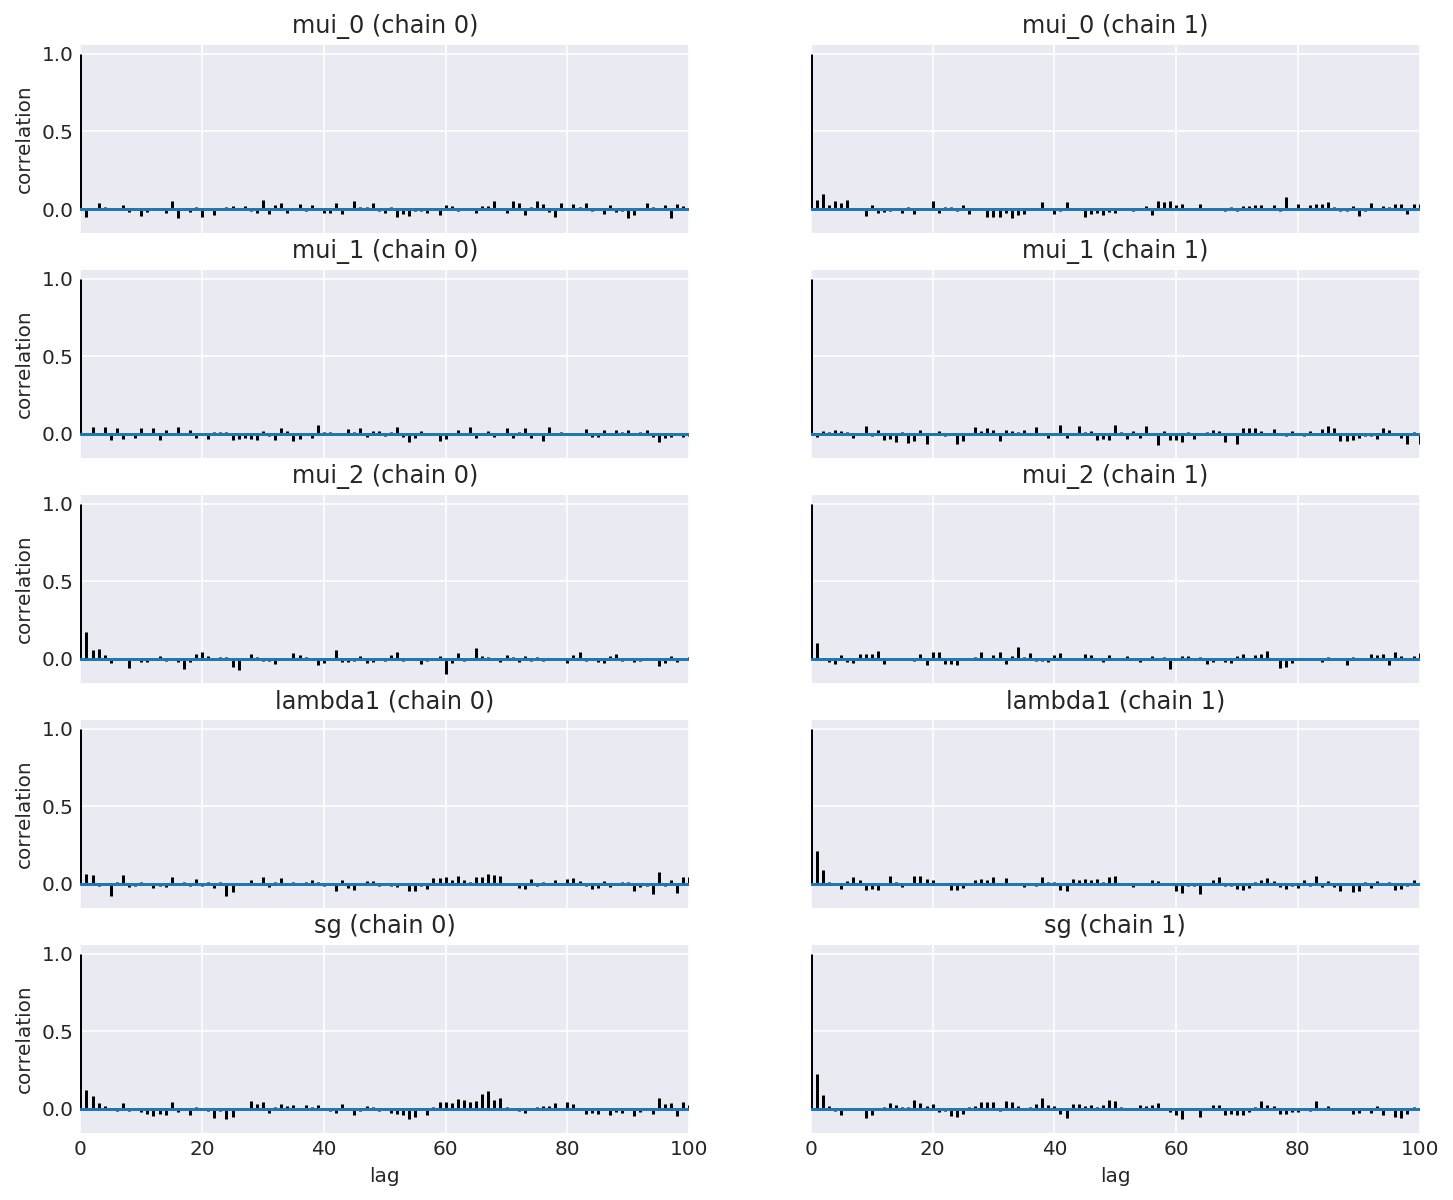

In [17]:
plots.autocorrplot(trace3)
plt.show()

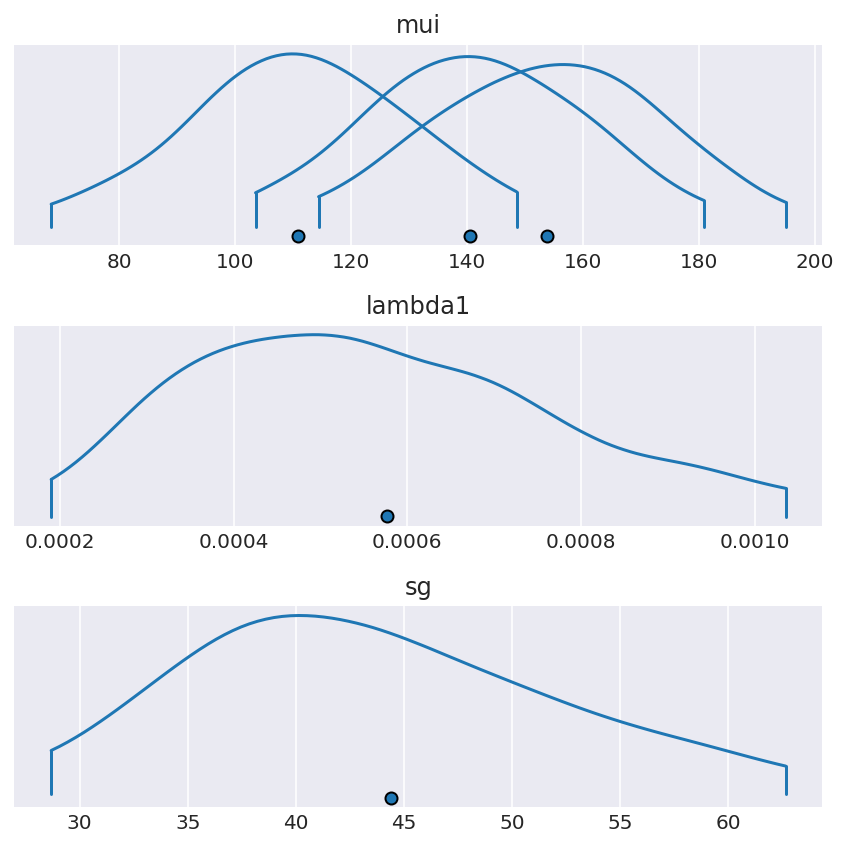

In [34]:
plots.densityplot(trace3)
plt.show()

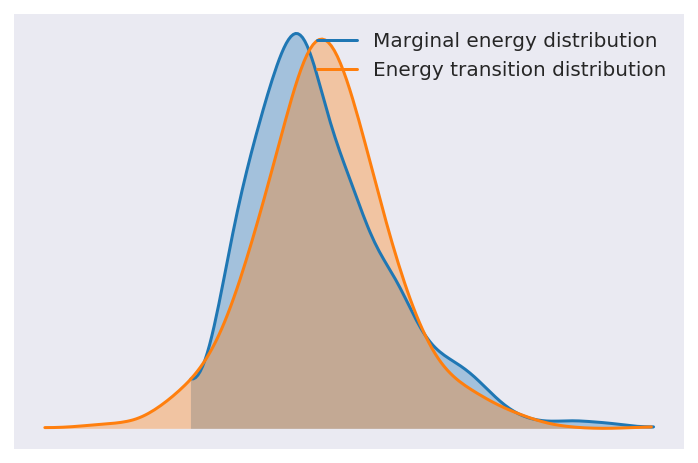

In [28]:
plots.energyplot(trace3)
plt.show()

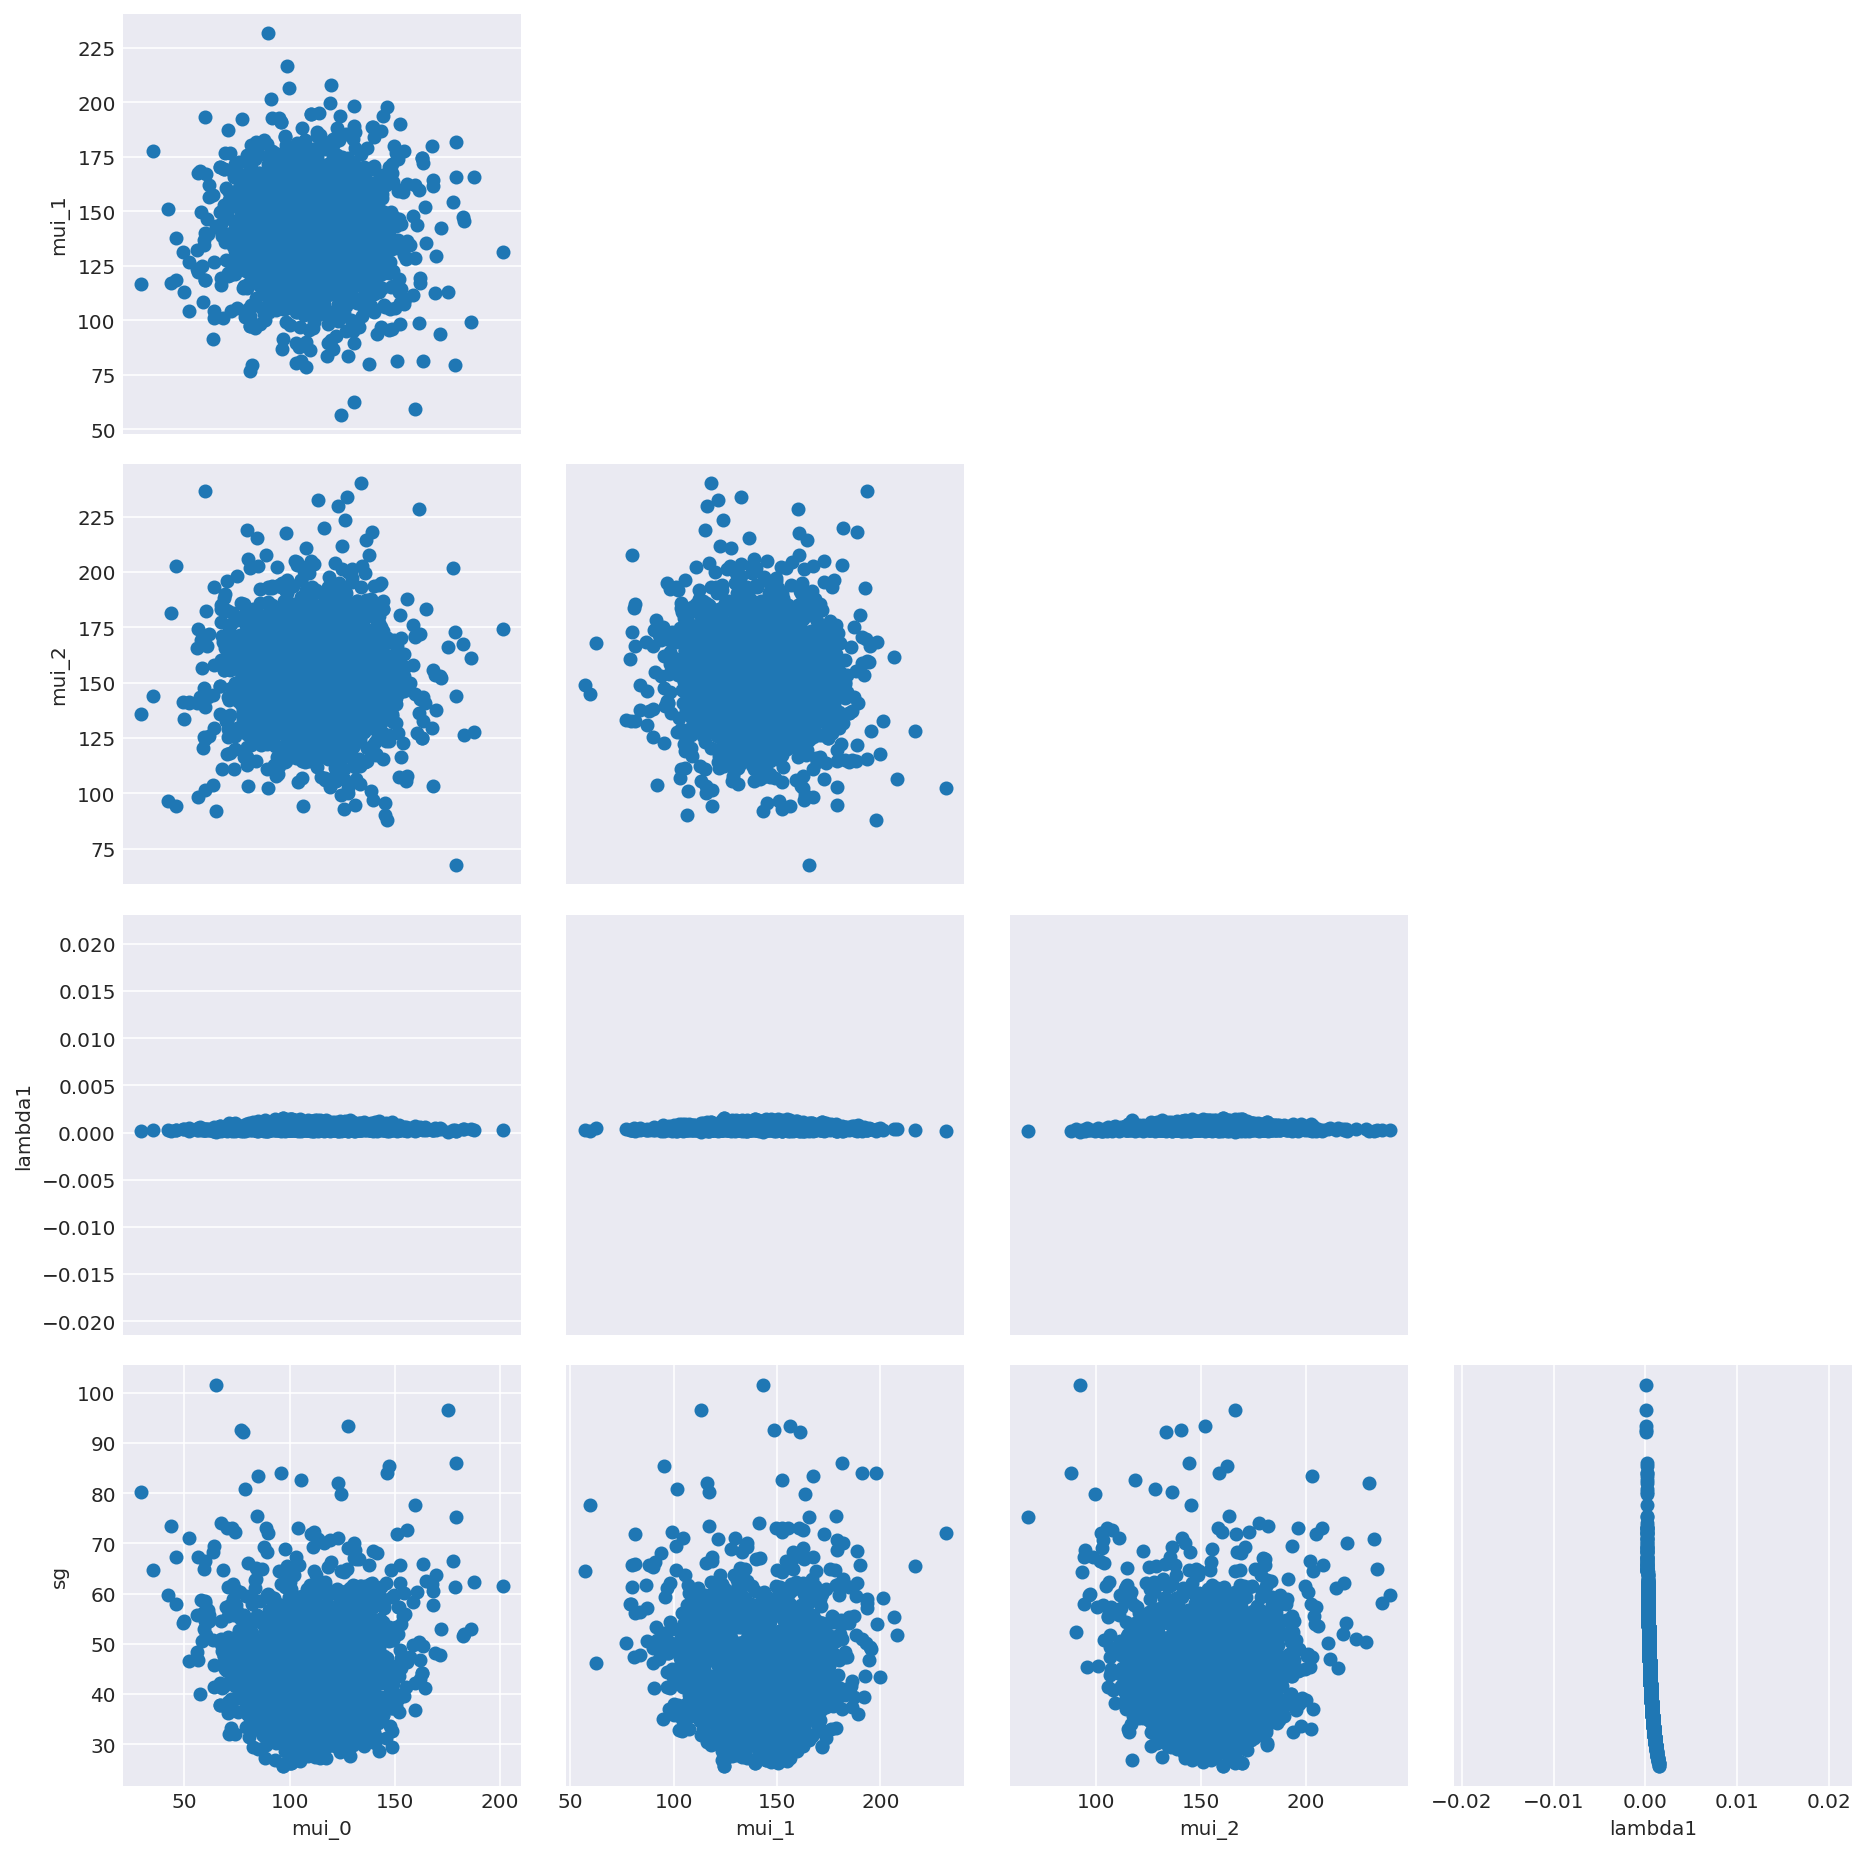

In [29]:
plots.pairplot(trace3)
plt.show()

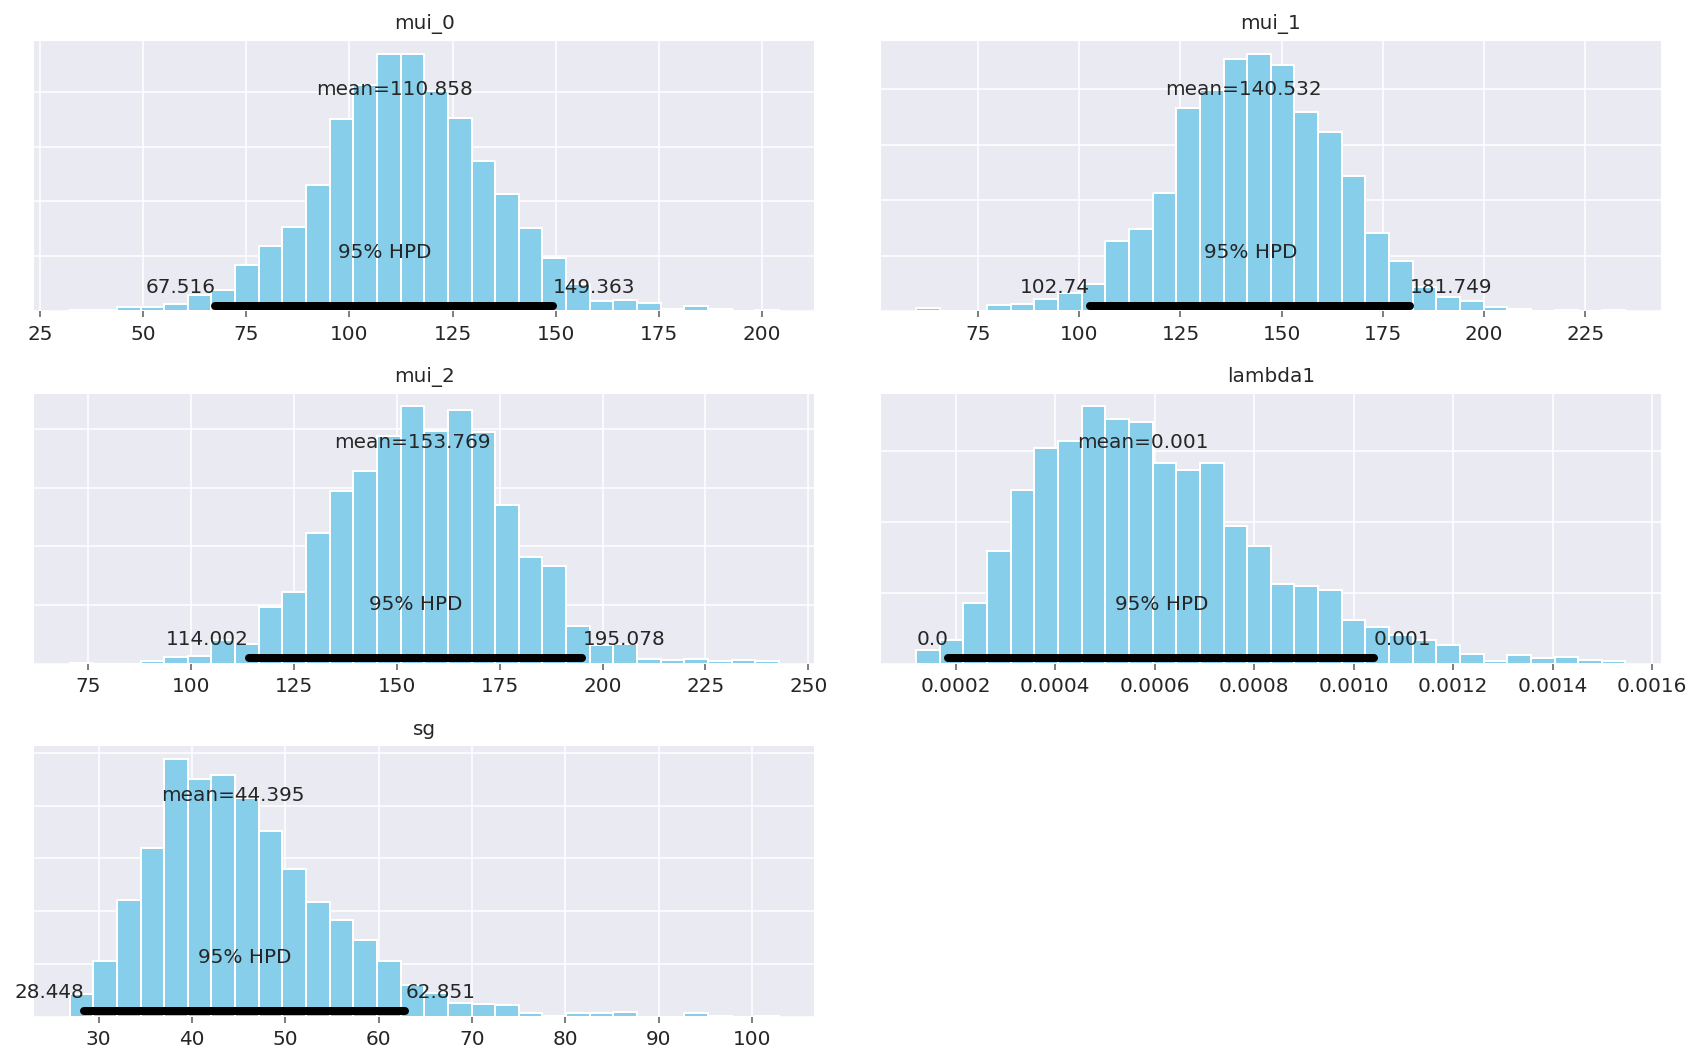

In [31]:
plots.plot_posterior(trace3)
plt.show()

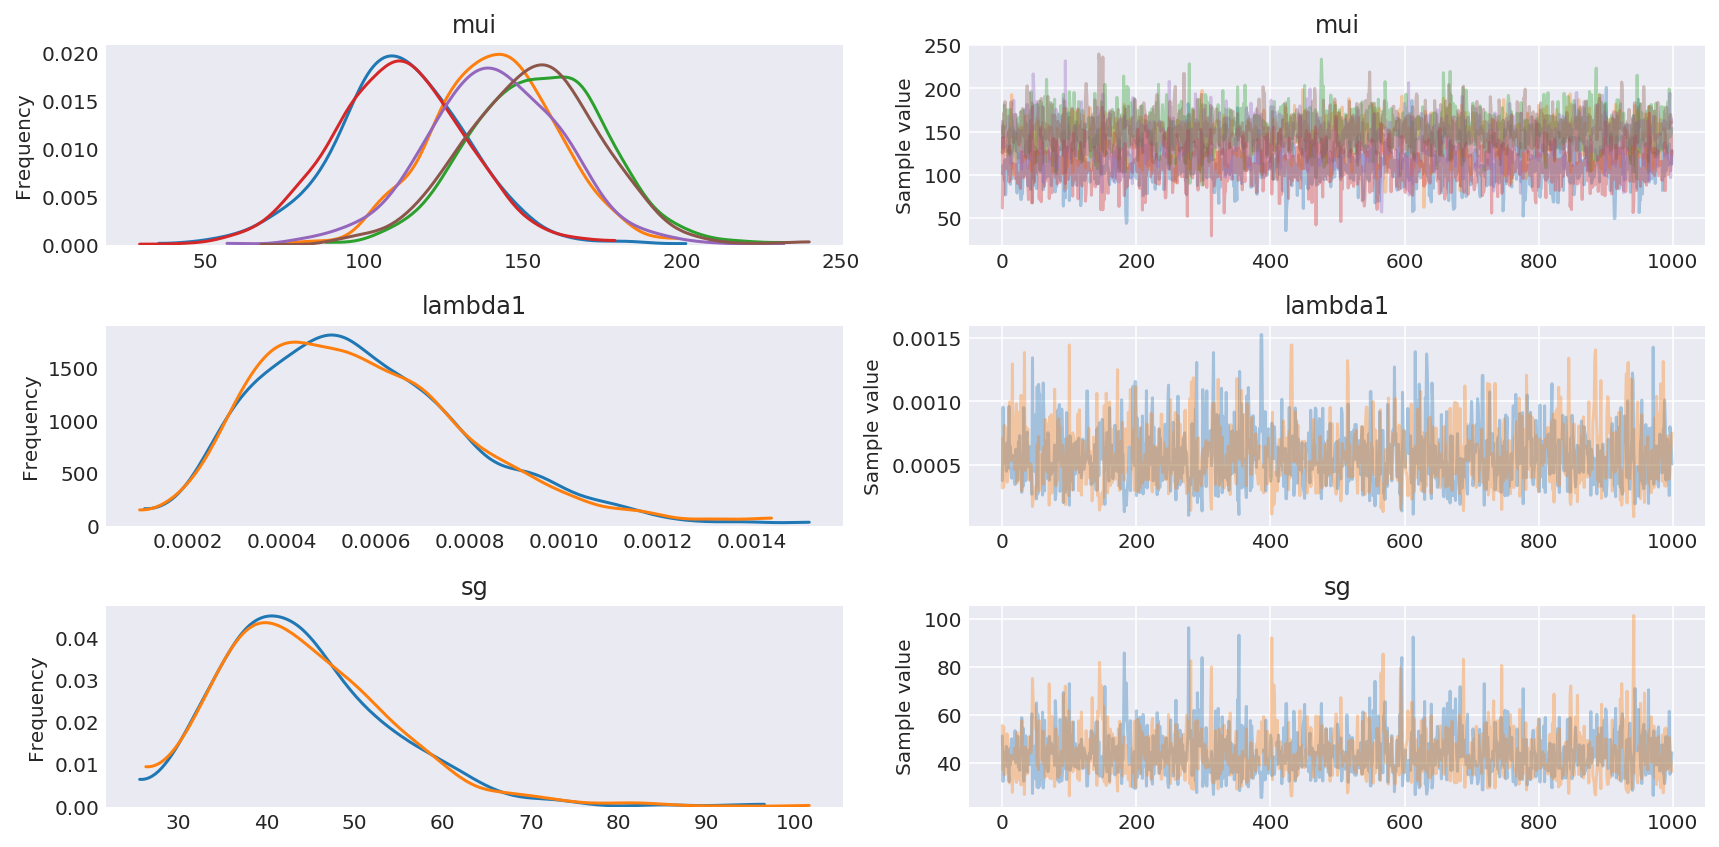

In [32]:
plots.traceplot(trace3)
plt.show()